Initially 2274 rows.
596 rows have missing EDSS values and will be dropped...


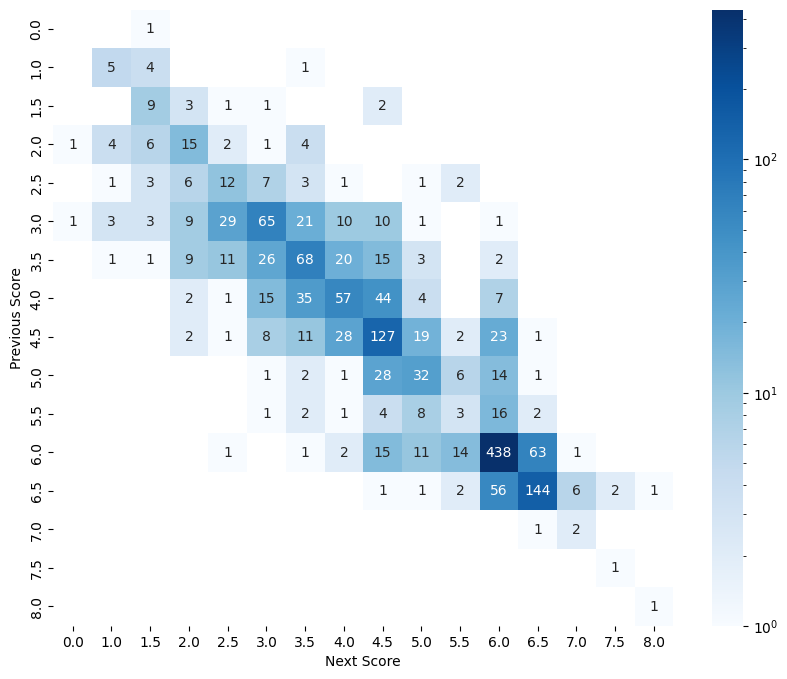

886 rows have a previous EDSS >= 5.0 and will be dropped...
0 rows have a previous EDSS < 0 and will be dropped...
43 rows have missing DMOs and will be dropped...
We have 46 progressions across 44 subjects, out of a total of 749 valid samples.


,Local.Participant,visit.number,age,gender,EDFSCR1L,time_since_diag,time_since_onset,Prev_EDSS,Prev_Timepoint,progression,...,ws_30_avg_w,strlen_30_avg_w,cadence_30_avg_w,strdur_30_avg_w,ws_30_p90_w,cadence_30_p90_w,ws_30_var_w,strlen_30_var_w,wb_60_sum_w,n_days_w
29,10382,T2,61.0,1,6.0,1.272356e+09,1.287476e+09,4.0,T1,1,...,0.84,106.0,94.0,1.25,1.00,103.0,17.0,16.0,7.0,7.0
46,10385,T4,41.0,0,6.0,3.045996e+08,3.656844e+08,4.5,T3,1,...,0.96,116.0,98.0,1.16,1.12,109.0,18.0,14.0,10.0,7.0
74,10393,T2,45.0,1,5.0,2.581911e+08,8.310231e+08,4.0,T1,1,...,0.83,118.0,84.0,1.35,1.03,98.0,19.0,13.0,3.0,7.0
77,10393,T5,46.0,1,6.0,3.052772e+08,8.781092e+08,4.5,T4,1,...,0.86,120.0,84.0,1.34,1.07,100.0,19.0,11.0,4.0,7.0
213,21138,T3,41.0,1,5.0,6.981414e+08,6.981414e+08,3.0,T2,1,...,0.83,111.0,88.0,1.28,0.97,95.0,19.0,14.0,2.0,7.0


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import os
from dotenv import load_dotenv

load_dotenv()

data_dir = os.getenv("DATA_DIR", "Dataset/")
min_prev_score = 0
threshold = 5.0

# read in main MS dataset
data_file_path = data_dir + r"MS_dataset_v.7.3.csv"
cols_from_dataset = ['Local.Participant', 'EDFSCR1L', 'visit.number', 'age', 'gender', 'mstypeonset', 'mstypediag', 'visit.date']
data = pd.read_csv(data_file_path, usecols=cols_from_dataset)

# forward fill within groups to ensure no leakage of demographics between participants
cols_from_dataset = [col for col in cols_from_dataset if col in ['age', 'gender', 'mstypeonset', 'mstypediag']]
for col in cols_from_dataset:
    data[col] = data.groupby('Local.Participant')[col].ffill()

# we need to get the time difference and convert from timedelta to something that the ML models can use - probably unix time
data['time_since_diag'] = (pd.to_datetime(data['visit.date']) - pd.to_datetime(data['mstypediag'])).dt.total_seconds()
data['time_since_onset'] = (pd.to_datetime(data['visit.date']) - pd.to_datetime(data['mstypeonset'])).dt.total_seconds()

# drop cols used for calculation
data = data.drop(['mstypeonset', 'mstypediag', 'visit.date'], axis=1)

# convert gender to 0 and 1
data['gender'] = data['gender'].map({'Male': 0, 'Female': 1})

# Crop down to just the necessary columns
data = data.sort_values(by=['Local.Participant', 'visit.number'])

# shift timepoints and EDSS to get previous as columns
data['Prev_EDSS'] = data.groupby('Local.Participant')['EDFSCR1L'].shift(1)
data['Prev_Timepoint'] = data.groupby('Local.Participant')['visit.number'].shift(1)

# get progression label column
progression_mask = (
    (data['Prev_EDSS'] < 5.0) &
    (data['EDFSCR1L'] >= 5.0) & 
    ((data['EDFSCR1L'] - data['Prev_EDSS']) >= 1.0)
)

data['progression'] = 0
data.loc[progression_mask, 'progression'] = 1

transitions = data[progression_mask]  # all the data where a transition happens, just in case.

data['Prev_Timepoint'] = data['Prev_Timepoint'].str.upper()  # needed for later merges
data['visit.number'] = data['visit.number'].str.upper()  # this one is just for consistency

#display(transitions.head(10))

# now that we have a reduced dataset, loop through our weekly dmo aggregations and append the relevant ones to the dataframe
timepoints = ["T1", "T2", "T3", "T4"]  # we don't need DMOs where T5 is previous

dfs_list = []
for timepoint in timepoints:
    feature_file_path = data_dir + f"/{timepoint} Aggregated DMO Data_V7.3/cvs-{timepoint}-weekly_agg_all-21-01-2026.csv"
    temp_df = pd.read_csv(feature_file_path)
    dfs_list.append(temp_df)

features_df = pd.concat(dfs_list, ignore_index=True)
data = pd.merge(data, features_df, left_on=['Local.Participant', 'Prev_Timepoint'],
                right_on=['participant_id', 'visit_type'], how='left')

data = data.drop(['participant_id', 'visit_type'], axis=1)
data = data.dropna(subset=['Prev_Timepoint'])

# Data cleaning - will monitor number of rows throughout
print(f"Initially {len(data)} rows.")

# get rid of participants where either current or previous EDSS is missing
count_before = len(data)
data = data.dropna(subset=['EDFSCR1L', 'Prev_EDSS'])
print(f"{count_before - len(data)} rows have missing EDSS values and will be dropped...")

# Create matrix of prev -> next EDSS scores
prev_scores = data['Prev_EDSS'].to_numpy().tolist()
next_scores = data['EDFSCR1L'].to_numpy().tolist()

# extract the unique scores
scores = list(set(prev_scores).union(set(next_scores)))
scores.sort()
n_scores = len(scores)

# Create transition matrix
transition_matrix = pd.DataFrame(
    np.zeros((n_scores, n_scores), dtype=int),
    index=scores,
    columns=scores)

for prev_score, next_score in zip(prev_scores, next_scores):
    transition_matrix.loc[prev_score, next_score] += 1

# Pretty print transition matrix as heatmap
plt.subplots(figsize=(10, 8))
ax = plt.subplot(111)
sns.heatmap(transition_matrix.values, annot=True, cmap="Blues", ax=ax, fmt='d', norm=colors.LogNorm())
ax.set_xlabel('Next Score')
ax.set_ylabel('Previous Score')
ax.xaxis.set_ticklabels(scores)
ax.yaxis.set_ticklabels(scores)
plt.show()

# Exclude participants with Prev_EDSS > threshold as they have already progressed:
# COMMENT OUT IF RUNNING MULTICLASS
count_before = len(data)
high_prev_edss_mask = (data['Prev_EDSS'] >= threshold)
print(f"{sum(high_prev_edss_mask)} rows have a previous EDSS >= {threshold} and will be dropped...")
data = data.drop(data[high_prev_edss_mask].index)

# Exclude participants with Prev_EDSS < min_prev_score as they are highly unlikely to progress, and may have different mobility patterns
count_before = len(data)
low_prev_edss_mask = (data['Prev_EDSS'] < min_prev_score)
print(f"{sum(low_prev_edss_mask)} rows have a previous EDSS < {min_prev_score} and will be dropped...")
data = data.drop(data[low_prev_edss_mask].index)

# drop all remaining NAN rows, which will be due to missing DMOs
count_before = len(data)
data = data.dropna()
print(f"{count_before - len(data)} rows have missing DMOs and will be dropped...")

num_progressions = len(data[data["progression"] == 1])
unique_sub_progressions = len(data[data["progression"] == 1]['Local.Participant'].unique())

print(
    f"We have {num_progressions} progressions across {unique_sub_progressions} subjects, out of a total of {len(data)} valid samples.")

display(data[data["progression"] == 1].head(5))

#data.to_csv("data.csv", index=False)

# need to be at least 1 (not 0.5) to change
# subset of EDSS and normalise?
# balance dataset - Done very good

# undersampled_df = labels_df.groupby('progression').sample(labels_df.groupby('progression').size().min())

ws_30_avg_w          0.128921
ws_30_p90_w          0.111324
ws_10_p90_w          0.109167
strlen_30_avg_w      0.104710
ws_1030_avg_w        0.087672
cadence_all_var_w    0.081241
cadence_30_p90_w     0.076457
cadence_30_avg_w     0.063477
strlen_1030_avg_w    0.062688
wbdur_all_p90_w      0.052501
cadence_all_avg_w    0.016086
wbdur_all_avg_w      0.014321
wb_60_sum_w          0.003560
gender               0.000498
wbdur_all_var_w     -0.005583
time_since_diag     -0.009301
ws_30_var_w         -0.020239
strdur_all_avg_w    -0.022721
strdur_all_var_w    -0.025310
wb_30_sum_w         -0.032816
n_days_w            -0.033219
strdur_30_avg_w     -0.064266
age                 -0.065125
wbsteps_all_sum_w   -0.070357
strlen_30_var_w     -0.081709
walkdur_all_sum_w   -0.084154
time_since_onset    -0.088754
wb_10_sum_w         -0.106185
wb_all_sum_w        -0.119198
dtype: float64

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

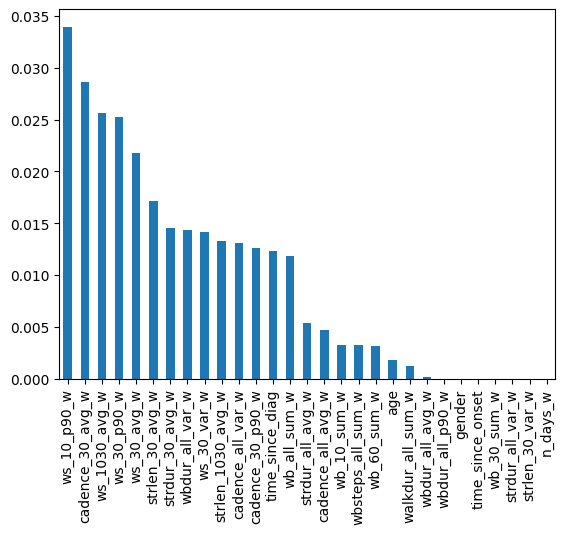

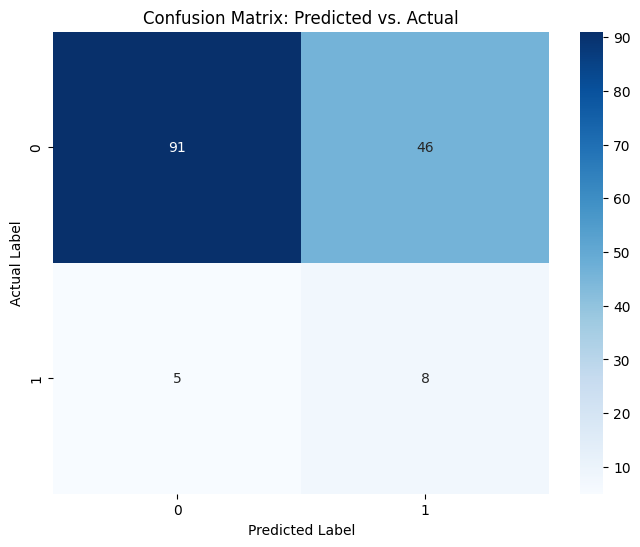

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi


KeyboardInterrupt


KeyboardInterrupt



In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import mutual_info_classif
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
import matplotlib.pyplot as plt
import seaborn as sns

do_data_sampling = False

def get_unsampled(x_data, x_sampled, y_data):
    # Create dataframe with column showing whether data has been sampled or not
    # Shown by column "_merge" value "both" == sampled "left_only" == not sampled
    merged = x_data.merge(x_sampled.drop_duplicates(), how='left', indicator=True)
    # Get indices of rows which have not been sampled
    unsampled_indices = merged.index[merged['_merge'] == "left_only"].tolist()
    X_unsampled = X_data.iloc[unsampled_indices]
    y_unsampled = y_data.iloc[unsampled_indices]
    return X_unsampled, y_unsampled


def do_cv(model, X_data, y_data, n_splits=5):

    scalar = StandardScaler()
    # require set_config(transform_output="pandas")
    # transformer = ColumnTransformer([('standard_scaler', ss, feature_cols)],
    #                                 remainder='passthrough',
    #                                 verbose_feature_names_out=False)

    combinedCM = None
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for i, (train_split_indices, test_split_indices) in enumerate(kf.split(X_data)):

        X_train_split = X_data.iloc[train_split_indices]
        X_test_split = X_data.iloc[test_split_indices]
        y_train_split = y_data.iloc[train_split_indices]
        y_test_split = y_data.iloc[test_split_indices]

        X_train_scaled = scalar.fit_transform(X_train_split)
        X_test_scaled = scalar.transform(X_test_split)

        # sample weighting
        sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_split)

        model.fit(X_train_scaled, y_train_split, sample_weight=sample_weights)

        y_pred = model.predict(X_test_scaled)

        cm = confusion_matrix(y_test_split, y_pred)
        if combinedCM is None:
            combinedCM = cm
        else:
            combinedCM = combinedCM + cm

    return combinedCM

def show_evaluation(X_test, y_test):
    y_pred = model.predict(X_test)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    plt.title('Confusion Matrix: Predicted vs. Actual')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

def feature_analysis(X, y):
    # feature importance analysis
    pearson_corr = X.corrwith(y).sort_values(ascending=False)
    display(pearson_corr)

    # mutual information gain for feature removal
    mi = mutual_info_classif(X, y, random_state = 42, n_jobs = -1)
    mi = pd.Series(data = mi, index = X.columns).sort_values(ascending=False)
    mi.plot(kind='bar')

    # delete features with 0 information gain
    mi = mi[mi != 0]
    
    X = X[mi.index]
    
    return X


# drop irrelevant or 'cheating' columns
y_data = data["progression"].reset_index(drop=True) # can be data["progression"] or data["multiclass_progression"]
labels_X_all = data.reset_index(drop=True)
X_data = data.drop(["progression", "Local.Participant", "EDFSCR1L",
                    "visit.number", "Prev_EDSS", "Prev_Timepoint"], axis=1)

if (do_data_sampling):
    rus = RandomUnderSampler(random_state=42)
    ros = RandomOverSampler(random_state=42)
    smote = SMOTE(random_state=42)
    adasyn = ADASYN(random_state=42)

    X_resampled, y_resampled = smote.fit_resample(X_data, y_data)
else:
    X_resampled = X_data
    y_resampled = y_data

X_resampled = feature_analysis(X_resampled, y_resampled)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# normalisation
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# sample weighting
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

model = BayesSearchCV(
    SVC(random_state=42),
    {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),  # Regularization parameter
        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),  # Kernel coefficient
        'kernel': Categorical(['rbf', 'poly', 'sigmoid']),  # Type of kernel
        'degree': Integer(1, 5)  # Degree for poly kernel
    },
    n_iter=20,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    cv=5
)

model.fit(X_train_scaled, y_train, sample_weight=sample_weights)

# Print the best parameters
print(f"Best Parameters: {model.best_params_}")
print(f"Best Score: {model.best_score_}")

show_evaluation(X_test_scaled, y_test)

if (do_data_sampling):
    # Following code tests with all the data points not used in training the model
    X_not_train, y_not_train = get_unsampled(X_data, X_train, y_data)
    X_not_train_scaled = scaler.fit_transform(X_not_train)
    show_evaluation(X_not_train_scaled, y_not_train)

# Annoyingly cross_val_score and cross_val_predict can differ ???

conf_mat = do_cv(model, X_data, y_data)

# Pretty print confusion matrix

ax = plt.subplot()

confusion_matrix = pd.DataFrame(conf_mat, range(2), range(2))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", ax=ax, fmt='d')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])
plt.show()

In [3]:
from sklearn.svm import SVC

svm_model = BayesSearchCV(
    SVC(random_state=42),
    {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),  # Regularization parameter
        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),  # Kernel coefficient
        'kernel': Categorical(['rbf', 'poly', 'sigmoid']),  # Type of kernel
        'degree': Integer(1, 5)  # Degree for poly kernel
    },
    n_iter=20,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    cv=5
)

from sklearn.neural_network import MLPClassifier

mlp_model = BayesSearchCV(
    MLPClassifier(random_state=42, max_iter=1000),
    {
        'hidden_layer_sizes': Integer(1, 128),  # Different architectures
        'activation': Categorical(['tanh', 'relu']),
        'solver': Categorical(['sgd', 'adam']),
        'alpha': Real(1e-5, 1e-1, prior='log-uniform'),  # L2 penalty (regularization)
        'learning_rate': Categorical(['constant', 'adaptive']),
        'learning_rate_init': Real(1e-4, 1e-1, prior='log-uniform')  # Initial learning rate
    },
    n_iter=20,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    cv=5
)

from sklearn.neighbors import KNeighborsClassifier

knn_model = BayesSearchCV(
    KNeighborsClassifier(),
    {
        'n_neighbors': Integer(1, 50),
        'weights': Categorical(['uniform', 'distance']),
        'algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size': Integer(10, 50),
        'p': Integer(1, 2)  # 1 = Manhattan, 2 = Euclidean distance
    },
    n_iter=20,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    cv=5
)

from xgboost import XGBClassifier

xgb_model = BayesSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    {
        'n_estimators': Integer(50, 500),
        'max_depth': Integer(3, 10),
        'learning_rate': Real(0.01, 1.0, prior='log-uniform'),
        'subsample': Real(0.5, 1.0, prior='uniform'),  # Fraction of samples used for fitting
        'colsample_bytree': Real(0.5, 1.0, prior='uniform'),  # Fraction of features used per tree
        'gamma': Real(1e-6, 5, prior='log-uniform'),  # Min loss reduction for split
        'reg_alpha': Real(1e-5, 10, prior='log-uniform'),  # L1 regularization
        'reg_lambda': Real(1e-5, 10, prior='log-uniform')  # L2 regularization
    },
    n_iter=20,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    cv=5
)

from sklearn.ensemble import RandomForestClassifier

rf_model = BayesSearchCV(
    RandomForestClassifier(random_state=42),
    {
        'n_estimators': Integer(50, 500),
        'max_depth': Integer(5, 50),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 10),
        'max_features': Categorical(['sqrt', 'log2', None]),  # Number of features to consider at each split
        'bootstrap': Categorical([True, False]),
        'criterion': Categorical(['gini', 'entropy'])
    },
    n_iter=20,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    cv=5
)

from sklearn.tree import DecisionTreeClassifier

dt_model = BayesSearchCV(
    DecisionTreeClassifier(random_state=42),
    {
        'criterion': Categorical(['gini', 'entropy']),
        'max_depth': Integer(3, 30),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 20),
        'max_features': Categorical(['sqrt', 'log2', None]),
        'ccp_alpha': Real(0.0, 0.1, prior='uniform')  # Cost-Complexity Pruning alpha
    },
    n_iter=20,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    cv=5
)

from sklearn.linear_model import LogisticRegression

lr_model = BayesSearchCV(
    LogisticRegression(random_state=42, solver='saga', max_iter=5000),
    {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),  # Inverse of regularization strength
        'penalty': Categorical(['l1', 'l2', 'elasticnet']),
        'l1_ratio': Real(0, 1, prior='uniform'),  # Only used if penalty='elasticnet'
        'fit_intercept': Categorical([True, False])
    },
    n_iter=20,
    random_state=42,
    verbose=0,
    n_jobs=-1,
    cv=5
)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


def fit_and_evaluate(model, model_name, X_train, X_test, y_train, y_test, X_resampled, y_resampled):
    print(f"\n{'=' * 40}")
    print(f"Training {model_name}...")
    print(f"{'=' * 40}")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    model_performance.append({
        'Model': model_name,
        'Best Score (CV)': model.best_score_,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Best Params': model.best_params_
    })

    print(f"Best CV Score: {model.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


# all models in one dict with names
models_dict = {
    "SVM": svm_model,
    "MLP": mlp_model,
    "KNN": knn_model,
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Decision Tree": dt_model,
    "Logistic Regression": lr_model
}

model_performance = []

for name, model in models_dict.items():
    fit_and_evaluate(model, name, X_train_scaled, X_test_scaled, y_train, y_test, X_resampled, y_resampled)

results_df = pd.DataFrame(model_performance)
results_df = results_df.sort_values(by='F1 Score', ascending=False)

# get best model and retrain
print("training best model...")
best_model = models_dict[results_df["Model"].iloc[0]]
best_model.fit(X_train_scaled, y_train)

print("\nModel Comparison Table:")
display(results_df)

In [ ]:
# un-normalise the data and try to find out which samples were misclassified
train_predictions = best_model.predict(X_train_scaled)
test_predictions = best_model.predict(X_test_scaled)

indexed_train_predictions = y_train.reset_index()
indexed_train_predictions["Prediction"] = train_predictions
indexed_train_predictions.index = indexed_train_predictions["index"]
indexed_train_predictions = indexed_train_predictions.drop(["index"], axis=1)

indexed_test_predictions = y_test.reset_index()
indexed_test_predictions["Prediction"] = test_predictions
indexed_test_predictions.index = indexed_test_predictions["index"]
indexed_test_predictions = indexed_test_predictions.drop(["index"], axis=1)

predictions_to_be_appended = pd.concat([indexed_train_predictions, indexed_test_predictions], axis=0)
predictions_to_be_appended["misclassified"] = abs(
    predictions_to_be_appended["Prediction"] - predictions_to_be_appended["progression"])
predictions_to_be_appended = predictions_to_be_appended.drop(["progression"], axis=1)

original_data_with_predictions = labels_X_all.join(predictions_to_be_appended)

display(original_data_with_predictions[original_data_with_predictions["misclassified"] == 1])

In [ ]:
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.4)

prog_group = original_data_with_predictions[original_data_with_predictions["progression"] == 1]
no_prog_group = original_data_with_predictions[original_data_with_predictions["progression"] == 0]

feature_cols = [c for c in original_data_with_predictions.columns if c != "progression"]

for col in feature_cols:
    plt.figure(figsize=(6, 4))

    if pd.api.types.is_numeric_dtype(original_data_with_predictions[col]):

        sns.kdeplot(data=no_prog_group, x=col, fill=True,
                    color='forestgreen', label='No Progression', alpha=0.3, linewidth=2)
        sns.kdeplot(data=prog_group, x=col, fill=True,
                    color='crimson', label='Progression', alpha=0.4, linewidth=2)

        plt.ylabel('Density')
        plt.legend()

    else:
        temp_df = original_data_with_predictions.groupby('progression')[col].value_counts(normalize=True).rename(
            'proportion').reset_index()
        temp_df['progression_label'] = temp_df['progression'].map({0: 'No Progression', 1: 'Progression'})

        sns.barplot(data=temp_df, x=col, y='proportion', hue='progression_label',
                    palette={'No Progression': 'forestgreen', 'Progression': 'crimson'}, edgecolor='black')

        plt.ylabel('Proportion')
        plt.legend(title=None)

    plt.title(f'{col}')
    plt.xlabel(col)

    sns.despine()

    plt.tight_layout()
    plt.show()